<a href="https://colab.research.google.com/github/siqisiqisiqisiqi/deep-learning-hw1/blob/main/hw1_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.conv import Conv2d
import matplotlib.pyplot as plt
import random

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [ ]:
label_mapping = list(range(10))
random.shuffle(label_mapping)
training_data = datasets.MNIST(root='./data', 
              train=True, 
              transform=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))]),
              target_transform=lambda y: label_mapping[y],
              download=True)
test_label_mapping = list(range(10))
random.shuffle(test_label_mapping)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))]),
    target_transform=lambda y: test_label_mapping[y]
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
random.shuffle(label_mapping)
print(label_mapping)
random.shuffle(label_mapping)
print(label_mapping)

[2, 5, 6, 1, 8, 3, 0, 7, 4, 9]
[5, 6, 4, 2, 7, 9, 8, 3, 1, 0]


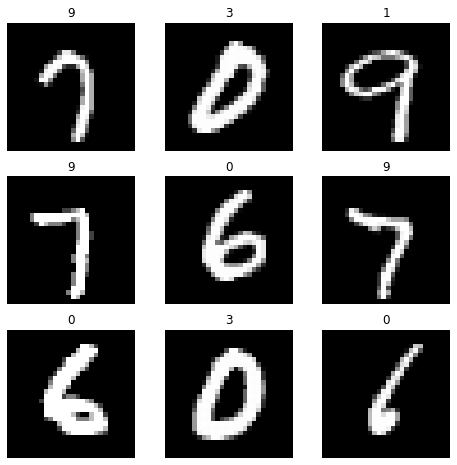

In [ ]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
train_loader = DataLoader(training_data, batch_size=batch_size_train, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
      super(NeuralNetwork, self).__init__()
      self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
      self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
      self.conv2_drop = nn.Dropout2d()
      self.fc1 = nn.Linear(320, 50)
      self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [ ]:
network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_accuracy = []
test_losses = []
train_counter = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    data, target = next(iter(test_loader))
    output = network(data)
    test_loss += F.nll_loss(output, target, size_average=False).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  # print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [ ]:
def train(epoch):
  # network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    network.train()
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      test()
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [ ]:
test()
n_epochs = 1
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

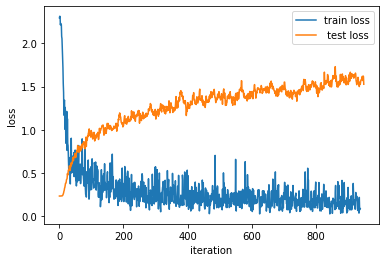

In [ ]:
plt.figure()
p0, = plt.plot(train_losses)
p1, = plt.plot(test_losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend([p0,p1],["train loss"," test loss"])